### 模块载入和数据读入

In [4]:
import warnings
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
os.chdir('D:/工作/data/shibie/')
warnings.filterwarnings('ignore')

#### 数据集合并

In [ ]:
X = pd .read_csv('train.csv')
y = pd.read_csv('train_label.csv')
train_data = pd.merge(X,y,left_on='ID', right_on='ID')
train_data.to_csv('train_data.csv',index=False)

In [5]:
train_data = pd.read_csv('train_data.csv')
test =pd.read_csv('test.csv')

#### 样本缺失值可视化
从下面可以看出样本缺失值存在明显的分层，所以我们通过缺失值将样本分为两个类，一个为缺失值个数大于50，一个为缺失值小于50，查看两个类别的样本失信率的区别。

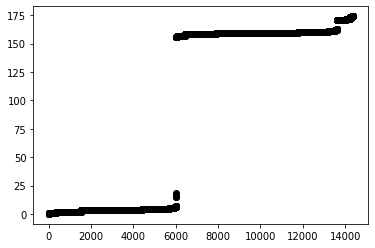

In [3]:
def plot_item_miss(data):
    ser = (data.isnull().sum(axis=1)).sort_values()
    x = range(data.shape[0])
    plt.scatter(x,ser.values,c='black')
plot_item_miss(train_data)

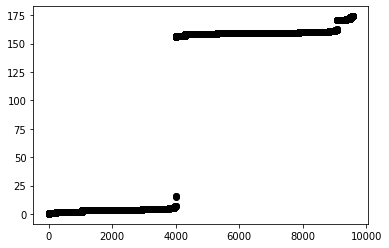

In [4]:
plot_item_miss(test)

In [6]:
train_data.select_dtypes(include='object').columns

Index(['经营期限至', '邮政编码', '核准日期', '注销时间', '经营期限自', '成立日期', '经营范围'], dtype='object')

### 数据处理
#### 类别数据
从分析可以知道数据中存在七个`object`类型，所以我们通过处理使得可以转化为数值。
- 经营期限至和注销时间中缺失值过多，直接编码。
- 经营期限自和成立日期，确定二者取值是否相同
- 核准日期主要为两类，其他的值很少，所以将其他的并为一类。
- 经营范围为列表，其中数值为编码，所以并不明白什么意识，所以去切分之后去长度，得到经营范围的个数。视为公司参与的领域的多少。
- 邮政编码取`[3,4]`两位，这两位代表县市，所以将企业按照县市进行分类。对于非邮政编码的数据，直接归为一类，复制为10，另成一类。

In [8]:
def func(x):
    item = str(x)[2:4]
    if item in ['60','63','61','65','67','62','64','66']:
        return int(item)
    else:
        return 10
    
def process(data):
    trainX = data.copy()
    trainX['经营期限至'] = pd.isnull(trainX['经营期限至']).astype(int)
    trainX['注销时间'] = pd.isnull(trainX['注销时间']).astype(int)
    trainX['equal']=(trainX['经营期限自']==trainX['成立日期']).astype(int)
    trainX['核准日期'] = trainX['核准日期'].map(
                lambda x: 0 if x=='00:00.0' else 1 if x=='42:06.0' else 2)
    trainX['经营范围'] = trainX['经营范围'].str.split(',').map(len)
    trainX = trainX.drop(['经营期限自','成立日期'],axis=1)
    nullmask = trainX['邮政编码'].isnull()
    temp = trainX.loc[~nullmask,'邮政编码']
    mask = temp.map(lambda x: all(map(str.isnumeric, 
                                        str(x).split('.'))))
    temp[mask] = temp[mask].map(func)
    temp[~mask] = 10
    trainX.loc[~nullmask,'邮政编码'] = temp
    trainX['邮政编码'] = trainX['邮政编码'].astype(np.float32)
    return trainX
train_data = process(train_data)
test = process(test)

In [11]:
from sklearn.model_selection import train_test_split

In [9]:
train_data.shape

(14366, 178)

In [12]:
train_data, valid = train_test_split(train_data, test_size=0.1, 
                      shuffle=True,stratify=train_data['Label'])

In [13]:
train_data['Label'].sum(),valid['Label'].sum()

(847, 94)

In [14]:
def drop_null(data):
    result = data.copy()
    mr = data.isnull().sum()/data.shape[0]
    mask = mr[mr==1].index
    result = result.drop(mask, axis=1)
    return result

def split_data(train_data1):
    # 按照缺失值数目对样本进行切分
    train2 = train_data1.copy()
    train2['miss'] = train2.isnull().sum(axis=1)
    train2['Cmiss'] = (train2['miss']>50).astype(int)
    mask = train2['Cmiss']==1
    cmiss1 = train2.loc[mask,:]
    cmiss2 = train2.loc[~mask,:]
    cmiss1 = cmiss1.drop('Cmiss', axis=1)
    cmiss2 = cmiss2.drop('Cmiss', axis=1)
    # 去除掉全部为缺失值的特征。
    cmiss4 = drop_null(cmiss2)
    cmiss3 = drop_null(cmiss1)
    ''' ['增值税', '企业所得税', '印花税','教育费', '城建税']存在大量0值，通过统计
    每个样本的零值的个数对样本进一步切分，对于不包含0值的归为一类，包含大于等于
    一个0值的归于一个类'''
    cmiss3['Count']= (cmiss3.iloc[:,-9:-4]==0).sum(axis=1)
    # 将0作为一类进行建模，将大于0作为一类进行建模
    mask = cmiss3['Count'] == 0
    cmiss5, cmiss7 = cmiss3.loc[mask,:], cmiss3.loc[~mask,:]
    return cmiss4, cmiss5, cmiss7

In [ ]:
def split_data(train_data1):
    # 按照缺失值数目对样本进行切分
    train2 = train_data1.copy()
    train2['miss'] = train2.isnull().sum(axis=1)
    train2['Cmiss'] = (train2['miss']>50).astype(int)
    mask = train2['Cmiss']==1
    cmiss1 = train2.loc[mask,:]
    cmiss2 = train2.loc[~mask,:]
    cmiss1 = cmiss1.drop('Cmiss', axis=1)
    cmiss2 = cmiss2.drop('Cmiss', axis=1)
    # 去除掉全部为缺失值的特征。
    cmiss4 = drop_null(cmiss2)
    cmiss3 = drop_null(cmiss1)
    fet = ['增值税', '企业所得税', '印花税','教育费', '城建税']
    cmiss3['Count']= (cmiss3.loc[:,fet]==0).sum(axis=1)
    for each in fet:
        cmiss3['is_null_'+each] = pd.isnull(cmiss3[each]).astype(int)
        cmiss3['bin_'+each] = pd.cut(cmiss3[each],bins=10,labels=range(1,11))
        cmiss3['bin_'+each]= cmiss3['bin_'+each].astype(int)
        cmiss3['bin_'+each] = cmiss3['bin_'+each].fillna(0)
    return cmiss3,cmiss4

In [15]:
cmiss1, cmiss2, cmiss3 = split_data(train_data)

In [16]:
cmiss1.shape,cmiss2.shape,cmiss3.shape

((5441, 179), (5284, 24), (2204, 24))

In [17]:
cmiss1['Label'].mean(), cmiss2['Label'].mean(),cmiss3['Label'].mean()

(0.005697482080499908, 0.023656320968962908, 0.3135208711433757)

In [199]:
test1, test2, test3 = split_data(test)

In [19]:
valid1, valid2, valid3 = split_data(valid)

In [20]:
valid1['Label'].mean(),valid2['Label'].mean(),valid3['Label'].mean()

(0.001718213058419244, 0.03420195439739414, 0.2987551867219917)

#### 对cmiss3进行数据处理

In [41]:
import lightgbm as lgb
import xgboost as xgb

paramxg={'base_score': 0.5, 'booster': 'gbtree','colsample_bylevel': 0.5,
 'colsample_bynode': 1,'colsample_bytree': 0.055,'gamma': 1.5,
 'learning_rate': 0.02,'max_delta_step': 0,'max_depth': 32,'min_child_weight': 57,
 'missing': None,'n_estimators': 1000,'n_jobs': -1,'objective': 'binary:logistic',
 'random_state': 7,'reg_alpha': 0,'reg_lambda': 0,
 'scale_pos_weight': 1,'subsample': 0.7,
 'verbosity': 1,'eval_metric': 'auc','early_stopping_rounds': 14}

paramlg = {'boosting_type': 'gbdt','class_weight': None,
 'colsample_bytree': 1.0,'importance_type': 'split','learning_rate': 0.005,
 'max_depth': 13,'min_child_samples': 20,'min_child_weight': 0.001,
 'min_split_gain': 0.0,'n_jobs': -1,'num_leaves': 20,'reg_alpha': 0.0,
'reg_lambda': 0.0,'subsample': 1.0,'subsample_for_bin': 200000,
'subsample_freq': 0,'metric': 'auc','is_training_metric': True,
 'max_bin': 55,'bagging_fraction': 0.8,'bagging_freq': 5,
 'feature_fraction': 0.9}

In [57]:
estimator1 = xgb.XGBClassifier(**paramxg)
pred1, pt1, ptrain1 = processTrainTest(cmiss1,valid1,estimator1,
                                       fs=True, valid=True)
estimator2 = xgb.XGBClassifier(**paramxg)
pred2, pt2, ptrain2 = processTrainTest(cmiss2,valid2,estimator2,
                                       fs=False, valid=True)
estimator3 = xgb.XGBClassifier(**paramxg)
pred3, pt3, ptrain3 = processTrainTest(cmiss3,valid3,estimator3,
                                       fs=False, valid=True)

In [60]:
estimator1 = lgb.LGBMClassifier(**paramlg)
pred1, pt1, ptrain1 = processTrainTest(cmiss1,valid1,estimator1,
                                       fs=True, valid=True)
estimator2 = lgb.LGBMClassifier(**paramlg)
pred2, pt2, ptrain2 = processTrainTest(cmiss2,valid2,estimator2,
                                       fs=False, valid=True)
estimator3 = lgb.LGBMClassifier(**paramlg)
pred3, pt3, ptrain3 = processTrainTest(cmiss3,valid3,estimator3,
                                       fs=False, valid=True)

In [61]:
pt1['pred'] = pred1
ptu1 = pt1[['ID','Label','pred']]

pt2['pred'] = pred2
ptu2 = pt2[['ID','Label','pred']]

pt3['pred'] = pred3
ptu3 = pt3[['ID','Label','pred']]

sub = pd.concat([ptu1,ptu2,ptu3])
roc_auc_score(sub['Label'], sub['pred'])

0.9025522409340789

In [102]:
pt1['pred'] = pred1
ptu1 = pt1[['ID','Label','pred']]

pt2['pred'] = pred2
ptu2 = pt2[['ID','Label','pred']]

pt3['pred'] = pred3
ptu3 = pt3[['ID','Label','pred']]

sub = pd.concat([ptu1,ptu2,ptu3])
roc_auc_score(sub['Label'],sub['pred'])

0.9025522409340789

In [103]:
pred1.min(),pred2.min(), pred3.min()

(0.003451922991105345, 0.014434125257885191, 0.19422949073375687)

In [105]:
roc_auc_score(ptu1['Label'],ptu1['pred'])

0.5679862306368331

In [91]:
np.median(pred1),np.median(pred2), np.median(pred3)

(0.0034551163024880973, 0.015277543138671773, 0.30370767720371816)

In [88]:
pred1.max(),pred2.max(), pred3.max()

(0.2386059366019534, 0.3458620123981136, 0.5672800650789386)

In [87]:
np.percentile(pred1,99),np.percentile(pred2,99),np.percentile(pred3,99)

(0.023353139540463183, 0.16818072682743748, 0.5520201698207421)

In [37]:
from sklearn.metrics import roc_auc_score
import sklearn.ensemble as ensemble

In [54]:
xg = xgb.XGBClassifier(**paramxg)
lg = lgb.LGBMClassifier(**paramlg)
X = train_data.drop(['ID','Label'], axis=1)
y = train_data['Label']
Xt = valid.drop(['ID','Label'], axis=1)
yt = valid['Label']
xg.fit(X,y)
lg.fit(X.values,y)
prelg = lg.predict_proba(Xt.values)[:,1]
prexg = xg.predict_proba(Xt)[:,1]
pre = (prelg+prexg)/2

In [106]:
test_data = test.drop('ID', axis=1)

In [107]:
prelg = lg.predict_proba(test_data.values)[:,1]
prexg = xg.predict_proba(test_data)[:,1]
pre = (prelg+prexg)/2

In [108]:
test['Label'] = pre
sub = test[['ID','Label']]
sub.to_csv('submit.csv',index=False)

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import cross_validate

In [3]:
import pandas as pd 
import numpy as np 

class TargetEncode:
    def __init__(self):
        self.map_ = {}
        self.mean_ = None
        self.none_ = {}
        
    def fit(self,X,y):
        self.mean_ = y.mean()
        name = y.name
        df = pd.concat([X,y],axis=1)
        for each in X:
            data = df.groupby(each)[name].mean()
            self.map_[each] = data.to_dict()
            self.none_[each] = y[pd.isnull(df[each])].mean()
        return self
    
    def transform(self,X):
        result = X.copy()
        for each in X:
            result[each] = X[each].map(
                lambda x,column=each: self.func(x,column) + self.mean_)
        return result
    
    def func(self,x,column=None):
        if pd.isnull(x):
            return self.none_.get(column,0)
        else:
            return self.map_[column].get(x,0)

class ProcessData:
    def __init__(self):
        self.enc = None
        self.cat_fet = ['企业类型',  '登记机关', '企业状态', '邮政编码', '核准日期',
 '行业代码', '行业门类', '企业类别', '管辖机关','经营范围']
        self.num_fet = ['增值税', '企业所得税', '印花税','教育费',
           '城建税','注册资本']
    
    def fit(self, X, y=None):
        result = X.copy()
        num, cat = result[self.num_fet], result[self.cat_fet]
        enc = TargetEncode()
        self.enc = enc.fit(cat, result['Label'])
        return self 

    def transform(self, X):
        result = X.copy()
        num, cat = result[self.num_fet], result[self.cat_fet]
        result['mean'] = num.mean(axis=1)
        result['std'] = num.std(axis=1)
        result['skew'] = num.skew(axis=1)
        result['median'] = num.median(axis=1)
        result[self.cat_fet] = self.enc.transform(cat)
        return result

def processTrainTest(cmiss1, test2, estimator1, fs=True, valid=False):
    pcmiss1 = ProcessData()
    pcmiss1.fit(cmiss1)
    presult1 = pcmiss1.transform(cmiss1)
    ptest1 = pcmiss1.transform(test2)

    presult1 = presult1.fillna(0)
    ptest1 = ptest1.fillna(0)

    pX1 = presult1.drop(['Label'],axis=1)
    py1 = presult1['Label']
    pX1 = pX1.drop(['ID','投资总额'],axis=1)
    pXt1 = ptest1.drop(['ID','投资总额'],axis=1)
    if valid:
        pXt1 = pXt1.drop(['Label'], axis=1)

    es1 = estimator1.fit(pX1.values,py1)
    if fs:
        dic ={key:value for key, value in zip(pX1.columns,
                            es1.feature_importances_) if value != 0}
        columns = list(dic.keys())
        es1 = estimator1.fit(pX1[columns].values, py1)
        pred1 = es1.predict_proba(pXt1[columns].values)[:,1]
    else:
        pred1 = es1.predict_proba(pXt1.values)[:,1]
    return pred1, ptest1, presult1

In [116]:
np.array([1,2,3])[:,None]

array([[1],
       [2],
       [3]])

In [113]:
np.array([[1,2],[3,4]]).ndim

2